# (F3022 Métodos Computacionais em Engenharia)
## Exame da época normal 
### 18 de Junho de 2025 (3h de duração)

A cotação de cada alínea aparece no início do respectivo enunciado, na escala de 100%.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
from scipy.sparse import diags

### Descrição do problema

Queremos considerar a propagação de um feixe de electrões através de uma dupla barreira de potencial.  O sistema simula (parcialmente) um díodo de túnel. Considere as barreiras de alturas $V_1 = 2 \text{eV}$ e $V_2 = 2 \text{eV}$ (que vamos tomar como iguais, ao contrário de um díodo de túnel de GaAs, por exemplo). A primeira situa-se entre $a=0 \text{nm}$ e $b = 0.4 \text{nm}$, e a segunda entre $c = 2.4 \text{nm}$ e $d = 2.8 \text{nm}$.

Se o electrão tiver energia $E$, a transmissividade do sistema, no estado estacionário, é dada simplesmente por $\mathcal{T} = |A_5|^2$, onde $A_5$ é a amplitude na zona $V$, ou seja, para lá da dupla barreira (estamos a considerar incidência da esquerda para a direita!). Queremos estudar este sistema usando a propagação do pacote de ondas. Usamos assim a equação de Schrödinger dependente do tempo, e não o estado estacionário.

<img src="potencial.png" alt="drawing" width="550"/>



Dados: $h=6.626\times10^{-34} \text{J.s}; e = 1.602\times10^{-19}\text{C}; m_e = 9.109\times 10^{-31}\text{kg}$.

#### Perguntas

a) [20] Escreva a equação de Schrödinger dependente do tempo, em unidades escaladas. Pode usar as chamadas unidades naturais, em que $\hbar =1$, e $m_e = 1$, ou usar as grandezas características que entender. Terá que escalar a energia, o tempo e a distância, de modo a ter na sua equação quantidades da ordem da unidade. Explique porquê.


$$
j\frac{d \psi}{dt} = -\frac{\hbar}{2m}\frac{d^2 \psi}{dx^2} + \frac{V}{\hbar}\psi
$$

$$
\hat{t} = \frac{t}{T}
$$

$$
\hat{x} = \frac{x}{L}
$$

$$
\frac{d^2 \psi}{dx^2} = \frac{d^2 \psi}{d\hat{x}^2}\frac{1}{L^2}
$$

$$
\frac{d \psi}{dt} = \frac{d \psi}{d\hat{t}}\frac{1}{T}
$$

Escolho $T = \frac{2mL^2}{\hbar}$, logo:

$$
j\frac{d \psi}{d\hat{t}} = -\frac{d^2 \psi}{d\hat{x}^2} + \frac{2mL^2}{\hbar^2} V\psi
$$

Escolho $\hat{V} = \frac{2mL^2}{\hbar^2} V$  logo:

$$
j\frac{d \psi}{d\hat{t}} = -\frac{d^2 \psi}{d\hat{x}^2} + \hat{V}\psi
$$

Como também quero escalar a energia por $V_1$ obtenho $L$:

$$
L^2 = \frac{\hbar^2}{2 m V_1}
$$

In [7]:
me = 9.109e-31
e = 1.602e-19
hbar = 6.626e-34 / (2 * np.pi)
V1 = 2 * e

L = np.sqrt(hbar**2 / (2 * me * V1))

a = 0.0
b = 0.4e-9 / L
c = 2.4e-9 / L
d = 2.8e-9 / L
print(d)

20.285376408275702


É importante tornarmos a equação adimensional de modo a não termos de usar números demasiado grandes ou demasiado pequenos, o que cria menos erros numéricos.

b) [15] Escreva uma função para obter a condição inicial que descreva um pacote de ondas descrevendo um electrão com energia $E$ (terá que variar a energia numa alínea mais abaixo). Justifique os valores escolhidos para as quantidades que usar para essa função.

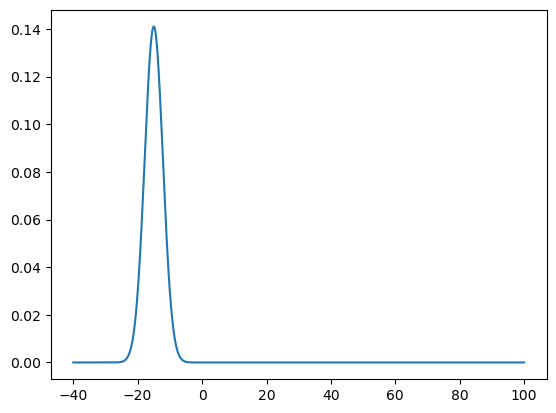

In [10]:
def psi0(x, dx, E=1, x0=-15, sigma=4):
    k0 = np.sqrt(E)
    psi = np.exp(1j * k0 * x) * np.exp(-(x-x0)**2 / (2 * sigma**2))
    norm = np.sqrt(np.sum(np.abs(psi)**2 * dx))
    return psi/norm

Nx = 2001
xx = np.linspace(-40, 100, Nx)
dx = xx[1] - xx[0]

plt.plot(xx, np.abs(psi0(xx, dx))**2)
plt.show()

Tenho de meter o $\psi_0$ à esquerda do potencial para ver bem como é que o potencial o influencia. O $\sigma$ só controla a largura da minha função de onda. O $x_0$ é o ponto onde está centrado.

c) [40] Escreva um código que lhe permita propagar o pacote inicial, sujeito a um potencial (que poderá ser arbitrário). Use um método numérico apropriado, comentando méritos e deméritos relativamente a outros métodos estudados. Tenha atenção às condições fronteira a usar e comente a sua escolha, e a influência dessa escolha no resultado obtido.

Mostre em gráfico(s) que os resultados do seu código produzem resultados esperados. Como pode obter a transmitãncia por este método?

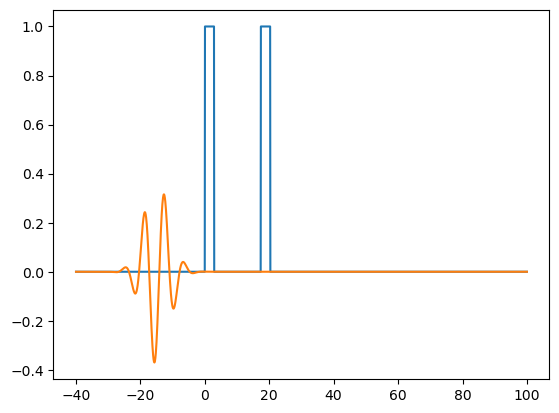

In [13]:
def V(x):
    if x < b and x > a:
        return 1
    if x < d and x > c:
        return 1
    return 0

VV = np.zeros(Nx, float)

for i, x in enumerate(xx):
    VV[i] = V(x)

plt.plot(xx, VV)
plt.plot(xx, np.real(psi0(xx, dx)))
plt.show()

Vou usar o método de Crank-Nicholson (CN), pois é incondicionalmente estável, é unitário, o que é essencial para este caso e tem precisão de 2ª ordem no tempo e no espaço.

Uma das alternativas era o Split-step fourier, mas penso que seria mais complexo de implementar, apesar de conseguir nesse caso precisão espectral e ser computacionalmente mais rápido.

Vou usar condições Neumann homogéneas de modo a não ter reflexões artificiais nas bordas.

In [16]:
def ES1D(N, dt, dx, VV): 
    alpha = 0.5 * dt / dx**2
    
    mainA = 1j - 2*alpha - 0.5 * dt * VV
    mainB = 1j + 2*alpha + 0.5 * dt * VV

    upper = np.full(N-1, alpha)
    lower = np.full(N-1, alpha)

    #Neumann
    upper[0] *= 2
    lower[-1] *= 2
    
    A = diags([mainA, lower, upper], offsets=[0, -1, 1], shape=(N, N), format='csc')
    B = diags([mainB, -lower, -upper], offsets=[0, -1, 1], shape=(N, N), format='csc')
    
    return spla.factorized(A), B

1.001304151556976


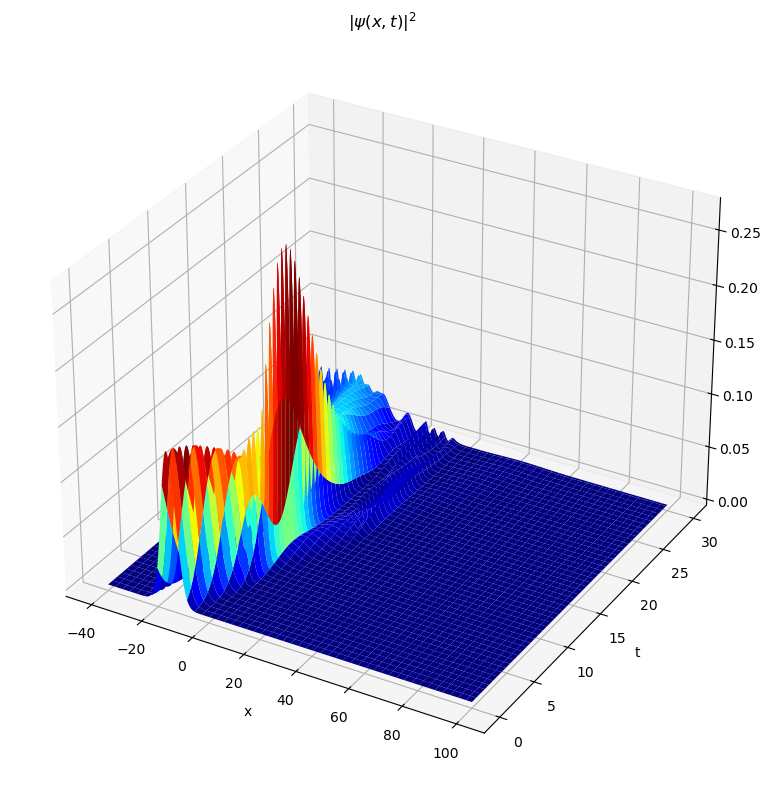

In [17]:
dt = 2 * dx**2
T = 30.0
Nt = int(T / dt) + 1

tt = np.linspace(0, T, Nt)
Asolve, B = ES1D(Nx, dt, dx, VV)

old = np.zeros(Nx, complex)
new = np.zeros(Nx, complex)
psis = np.zeros((Nt, Nx), complex)

old = psi0(xx, dx, E=0.5)

for i in range(Nt):
    new = Asolve(B @ old)
    old = new.copy()
    psis[i, :] = new

X, T = np.meshgrid(xx, tt)

print(np.sum(np.abs(new)**2 * dx))

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X,T, np.abs(psis)**2, cmap='jet')
plt.xlabel('x')
plt.ylabel('t')
plt.title(r'$|\psi(x, t)|^2$')
plt.tight_layout()
plt.show()

Isto bate certo, pois eu meti a energia menor que $V_1$ logo a função de onda não tem energia suficiente para ultrapassar o potencial significativamente.

Depois do potencial decresce exponencialmente.

1.0036892213340767


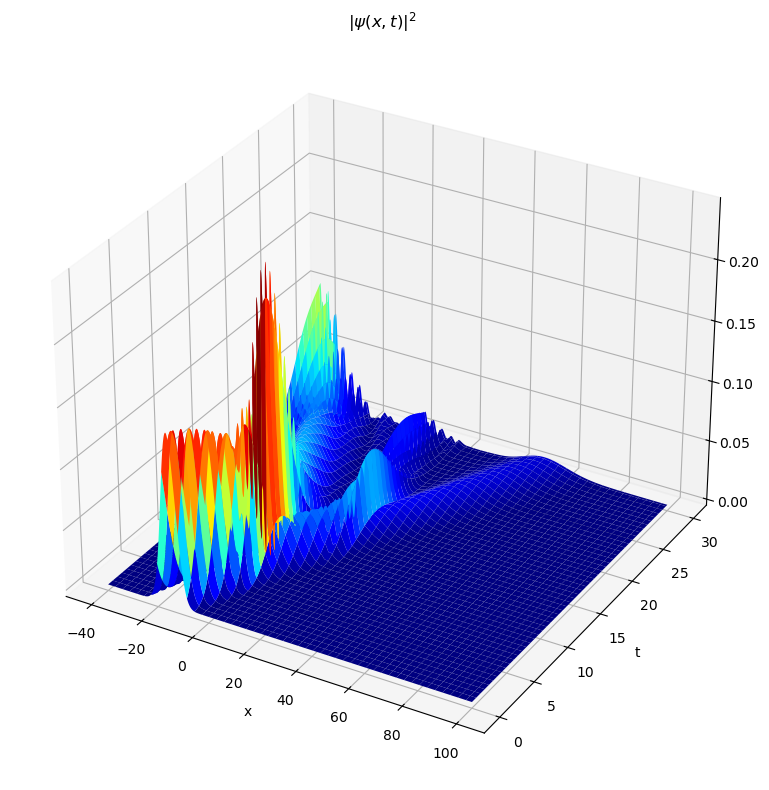

In [19]:
old = np.zeros(Nx, complex)
new = np.zeros(Nx, complex)
psis = np.zeros((Nt, Nx), complex)
old = psi0(xx, dx, E=1.0)

for i in range(Nt):
    new = Asolve(B @ old)
    old = new.copy()
    psis[i, :] = new

X, T = np.meshgrid(xx, tt)

print(np.sum(np.abs(new)**2 * dx))

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X,T, np.abs(psis)**2, cmap='jet')
plt.xlabel('x')
plt.ylabel('t')
plt.title(r'$|\psi(x, t)|^2$')
plt.tight_layout()
plt.show()

Como é possível observar já existe mais probabilidade de a partícula ultrapassar o 1º potencial, mas não consegue ultrapassar significativamente o 2º.

1.001444084281592


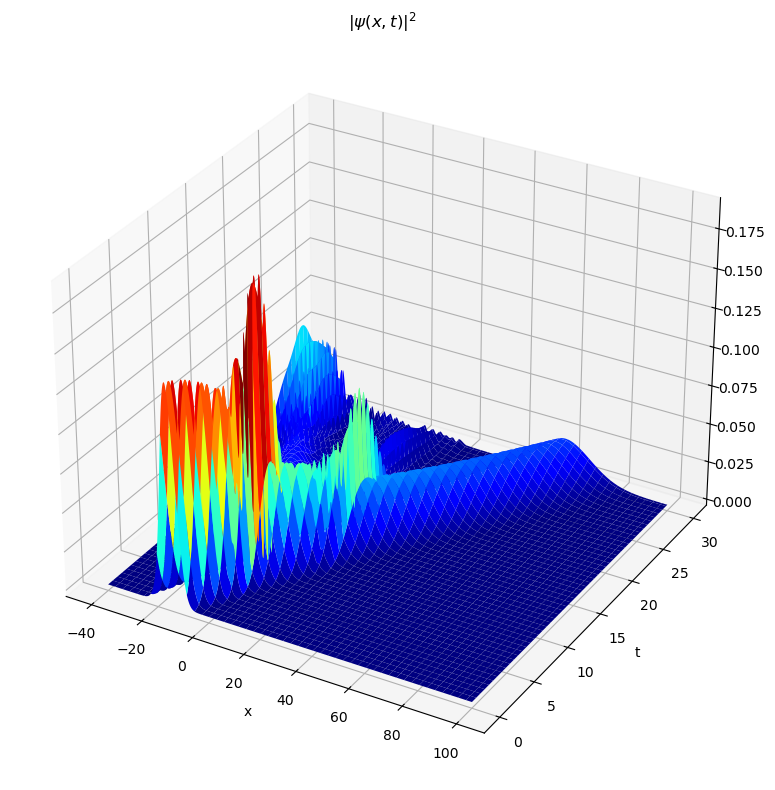

In [21]:
old = np.zeros(Nx, complex)
new = np.zeros(Nx, complex)
psis = np.zeros((Nt, Nx), complex)

old = psi0(xx, dx, E=1.5)

for i in range(Nt):
    new = Asolve(B @ old)
    old = new.copy()
    psis[i, :] = new

print(np.sum(np.abs(new)**2 * dx))

X, T = np.meshgrid(xx, tt)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X,T, np.abs(psis)**2, cmap='jet')
plt.xlabel('x')
plt.ylabel('t')
plt.title(r'$|\psi(x, t)|^2$')
plt.tight_layout()
plt.show()

Aqui já ultrapassa significativamente o 2º potencial.

A transmitância é obtida da seguinte forma:

$\mathcal{T} = \int_{d}^{\infty} \, \, |\psi(x, t)|^2 dx$

Como é óbvio eu não consigo simular aqui o  infinito, por isso o infinito é o limite da minha janela.

d) [15] Obtenha um gráfico da transmitânca $\mathcal{T}$ em função da energia $E$ no intervalo $[1, 2]\text{eV}$. No tempo disponível, tente obter uma curva o mais detalhada possível. Comente os resultados.

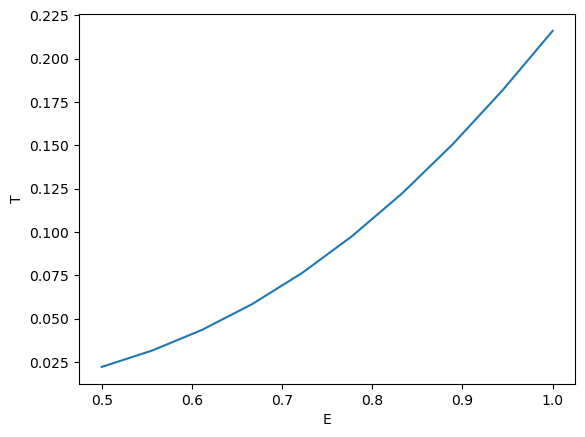

In [26]:
EE = np.linspace(0.5, 1, 10)
TT = np.zeros_like(EE)

for j, E in enumerate(EE):
    old = np.zeros(Nx, complex)
    new = np.zeros(Nx, complex)
    
    old = psi0(xx, dx, E)
    
    for i in range(Nt):
        new = Asolve(B @ old)
        old = new.copy()
    
    TT[j] = np.sum(np.abs(new[xx>d])**2 * dx)

plt.plot(EE, TT)
plt.xlabel('E')
plt.ylabel('T')
plt.show()

É possível observar uma relação do tipo $\mathcal{T} \propto e^{E}$.

Primeiro é importante realçar que estas energias são menores ou iguais à do potencial, pelo que a transmitância é baixa (menor que 0.225).

Observamos que a transmitância aumenta com o aumento da energia como esperado.

e) [10] Se pretendermos uma aproximação melhor, podemos usar a discretização do laplaciano com uma fórmula de 9 pontos em vez de 5. Uma possibilidade é:
$$\nabla^2u\approx \frac{-20u_{i,j} + 4u_{i+1,j} + 4u_{i-1,j} + 4u_{i,j+1} + 4u_{i,j-1} + u_{i+1,j+1} + u_{i−1,j-1} + u_{i+1,j-1} + u_{i-1,j+1}}{6h^2}.$$


Usando expansões em série de Taxlor das diferentes parcelas, prove que este esquema tem uma precisão de ordem $\mathcal{O}(h^4)$, onde $dx=dx=h.$

`No caderno`

$$
\nabla^2 u \approx u_{xx} + u_{yy} + \mathcal{O}(h^4)
$$

Em que $u_{ii}$ representa a segunda derivada de u em relação a i.